# ECE133A Winter 2023 Final Project
## Aaron Isara 905563052, Sudarshan Seshadri 105490936
### March 3, 2023

This notebook is the best way to view the project report. The report is also available as a LaTeX file in the repository.

# 1. Introduction
This section 1 is due February 21, 2023 at 11:59pm.

## 1.1. Dataset Description

We are using the [US Accidents (2016 - 2021) dataset compiled by Sobhan Moosavi and colleagues](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), which contains a set of 2.9 million traffic accident entries occurring in the United States between 2016 and 2021 described by a set of 43 features.\
\
We intend to clean the dataset to remove features that cannot be translated directly to numerical values or which very likely would not have an impact on the predictive capabilities of the model. Below is a description of the features we intend to use, which have been selected and/or derived from the original 43:




1.  Numeric

    1.  *Distance* (mi): Distance over which accident occurred

    2.  *Humidity* (%): Humidity during the accident

    3.  *Pressure* (in): Barometric pressure during the accident

    4.  *Severity*: Categorical rating of severity of accident from 1 to
        4 based on effect on level of traffic disruption, with 1 being
        the least disruption.

    5.  *Start Latitude*: Latitude of start of accident

    6.  *Start Longitude*: Longitude of start of accident

    7.  *Start Time* (s): The time of the accident represent as a Unix
        timestamp

    8.  *Temperature* ($^{\circ}$F): Local temperature during the
        accident

    9.  *Visibility* (mi): Visibility during the accident

2.  Binary

    1.  *Amenity*: Was there an amenity nearby the accident?

    2.  *Astronomical Twilight*: Did the accident occur during the night
        with respect to astronomical twilight?

    3.  *Bump*: Was there a speed bump nearby the accident?

    4.  *Civil Twilight*: Did the accident occur during the night with
        respect to civil twilight?

    5.  *Crossing*: Was there a traffic crossing nearby the accident?

    6.  *Give way*: Was there a give way traffic sign nearby the
        accident?

    7.  *No exit*: Was there a no exit sign nearby the accident?

    8.  *Railway*: Was there a railway nearby the accident?

    9.  *Roundabout*: Was there a roundabout nearby the accident?

    10. *Side*: Did the accident occur on the left side of the street?

    11. *State* (one-hot encoded): Which state the accident occurred in

    12. *Station*: Was there a station nearby the accident?

    13. *Stop*: Was there a stop sign nearby the accident?

    14. *Sunrise/Sunset*: Did the accident occur during the night with
        respect to sunrise/sunset?

    15. *Traffic Calming*: Was there a traffic calming structure nearby
        the accident?

    16. *Traffic Signal*: Was there a traffic signal nearby the
        accident?

    17. *Weather Condition* (one-hot encoded): What was the category of
        weather conditions during the accident

3.  Derived

    1.  *Amount of Light*: Derived from *Start Time*; A heuristic for
        the level of light present during the accident, based on the
        hour of the day

    2.  *Day Number*: Derived from Start Time; The day in the year the
        accident occurred (with 0 representing January 1st and 364
        representing December 31st)

    3.  *Hour* (one-hot encoded): Derived from *Start Time*; What hour
        the accident occurred in during the day

    4.  *Seconds Since Start of Day:* (s): Derived from *Start Time*; Number of
        seconds since 12:00 AM on the day of the accident

    5.  *Wind Vector X-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The x-component of the wind's vector at the
        time of the accident

    6.  *Wind Vector Y-component* (mi/hr): Derived from *Wind Direction*
        and *Wind Speed*; The y-component of the wind's vector at the
        time of the accident

## 1.2. Problem Description

We will perform a classification on the data to predict the severity of
an accident given the remaining input features.


## 1.3. Project Plan

We intend to begin by simply performing binary classification on the
data, classifying between a severity of 1 to 2 and a severity of 3 to 4.
If the model's test accuracy is not high enough (less than 80%
accuracy), then we may try introducing more features derived from the
originals. After settling on a good feature set, we will then attempt
multi classification by training 4 one-versus-all binary classifiers,
one for each severity category, and predicting severity by selecting the
category whose classifier scored the highest in its favor. We may also
experiment with one-versus-one binary classifiers if time permits.

# 2. Datastructure

This section 2 is due February 28, 2023 at 11:59pm.


We begin by importing the necessary libraries and loading the dataset. Note that for now, we will be using a subset of the data, containing only the first 10,000 entries, to speed up the development process. We will later switch to the full dataset once we have a fully working model.

In [31]:
import numpy as np
import pandas as pd
import pickle
import sklearn.cluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# csv_file_name = "final_data_crashes.csv"
csv_file_name = "final_data_crashes_small.csv"
df = pd.read_csv(csv_file_name)

# create a new df that is just df but with only 10,000 random rows. Save it to a new csv file. Uncomment to run (takes a while, but only needs to be run once as long as the csv file is saved)
# df_small = df.sample(n=10000)
# df_small.to_csv("final_data_crashes_small.csv")
# df = df_small

We will store sereral representations of the data to use with different libraries.

In [32]:
cols = []
for col in df.items():
    cols.append(col[1].tolist())
data = list(zip(*cols))

datanp = np.array(data)
datapd = pd.DataFrame(datanp)
pd.options.display.max_columns = datanp.shape[1]

# store the column names
col_names = []
for j in range(len(df.columns)):
    column_name = df.columns[j]
    # print('    Column', column_name)
    col_names.append(column_name)

## 2.1 Standardization

Below is a matrix containing relevant statistics for each of the feature
columns. This is before we standardize our features. Notice that the mean and standard deviation are very different for each feature, which is why we will standardize our features.

In [33]:
display(datapd.describe(include = 'all'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158
count,10000.000000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0000,10000.000000,10000.0000,10000.00000,10000.00000,10000.0000,10000.0000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,2.145700,1.595952e+09,212.924900,48008.657200,2.513450e+04,36.222605,-96.999401,0.692127,0.826000,61.430110,60.264490,64.776700,29.468376,9.073448,7.37545,0.005468,-1.035877,-0.362078,0.009200,0.000300,0.069300,0.001700,0.099100,0.001700,0.008100,0.0,0.024700,0.021400,0.000500,0.089900,0.0,0.633600,0.676800,0.725600,0.76680,0.060100,0.126700,0.002200,0.000600,0.395700,0.005200,0.016100,0.0,0.011400,0.000200,0.004800,0.000400,0.000600,0.001000,0.0001,0.0,0.002400,0.0001,0.0001,0.000500,0.048600,0.001700,0.001500,0.013900,0.000900,0.000300,0.000500,0.131400,0.002300,0.00070,0.035500,0.087200,0.00210,0.000600,0.011600,0.0001,0.017800,0.000400,0.0,0.002400,0.002300,0.0001,0.002800,0.0001,0.00210,0.00350,0.0001,0.0001,0.001200,0.006300,0.004000,0.0184,0.278800,0.00830,0.010500,0.003300,0.002700,0.143700,0.012900,0.003200,0.003400,0.017000,0.008900,0.003100,0.002900,0.017800,0.002200,0.020800,0.001300,0.016600,0.035400,0.011100,0.001000,0.005300,0.031900,0.001000,0.000800,0.000800,0.018000,0.00070,0.002000,0.036700,0.009200,0.00440,0.042300,0.035100,0.001700,0.033700,0.0,0.019500,0.053600,0.016800,0.036200,0.0,0.010400,0.003900,0.002200,0.000200,12.832900,0.022000,0.020700,0.0184,0.016800,0.016900,0.030900,0.038200,0.05060,0.049000,0.042000,0.033100,0.036600,0.048500,0.053300,0.06660,0.074200,0.076000,0.080100,0.064400,0.042500,0.031700,0.032700,0.02990,0.024900,6.996300
std,0.496081,4.675195e+07,112.075236,20997.601145,5.955393e+05,5.356568,18

Now we standardize the features so that the mean and standard deviation are 0 and 1, respectively.
One-hot encoded features were not ignored, but are not
particularly insightful.

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(datanp)
datanp_normalized = scaler.transform(datanp)
datapd_normalized = pd.DataFrame(datanp_normalized)
display(datapd_normalized.describe(include = 'all'))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-3.439027e-16,1.778666e-15,-7.460699e-17,-7.052137e-17,7.105427e-19,-5.537970e-15,1.863327e-14,1.463718e-16,1.008971e-16,8.105516e-16,-7.924328e-16,-2.430056e-16,-3.070042e-14,3.048228e-16,-1.594458e-15,8.526513e-17,-2.209788e-16,5.471179e-17,2.948752e-17,3.197442e-18,1.492140e-17,2.380318e-17,1.740830e-17,2.309264e-17,1.776357e-18,0.0,3.126388e-17,2.238210e-17,1.421085e-18,8.011369e-17,0.0,-1.257661e-16,8.064660e-17,-2.167155e-17,-1.172396e-16,3.339551e-17,-3.996803e-18,-2.131628e-17,1.705303e-17,1.264766e-16,2.557954e-17,9.237056e-18,0.0,-1.953993e-17,-1.776357e-17,-3.694822e-17,1.030287e-17,1.278977e-17,-1.278977e-17,-4.973799e-18,0.0,3.126388e-17,-2.131628e-18,-1.101341e-17,1.705303e-17,5.613288e-17,-1.527667e-17,6.394885e-18,1.918465e-17,1.421085e-17,1.065814e-17,1.101341e-17,5.897505e-17,-6.394885e-18,-1.136868e-17,-1.918465e-17,5.986323e-17,-5.684342e-18,1.634248e-17,-3.126388e-17,-2.842171e-18,-3.552714e-17,9.947598e-18,0.0,7.105427e-18,-2.593481e-17,-5.684342e-18,4.547474e-17,-5.684342e-18,3.197442e-17,8.526513e-18,-6.394885e-18,-1.136868e-17,2.273737e-17,-2.309264e-17,-4.334311e-17,-1.278977e-17,4.263256e-17,-1.634248e-17,-3.694822e-17,3.197442e-18,-3.197442e-18,2.984279e-17,3.126388e-17,7.815970e-18,7.815970e-18,-5.542233e-17,6.323830e-17,-5.400125e-17,4.689582e-17,-1.705303e-17,-1.634248e-17,-1.421085e-17,3.552714e-18,1.278977e-17,1.652012e-17,-4.405365e-17,9.947598e-18,-3.375078e-18,7.531753e-1

## 2.2 $k$-means Clustering
To determine the best $k$, we performed k-means clustering for
$k = 1 \dots 9$ and plotted the inertia of the model for each $k$. Using
the elbow heuristic, we determined that the best $k$ is $k = 3$, as it
is the point after which the inertia seems to decrease linearly. Below
is the relevant plot:\

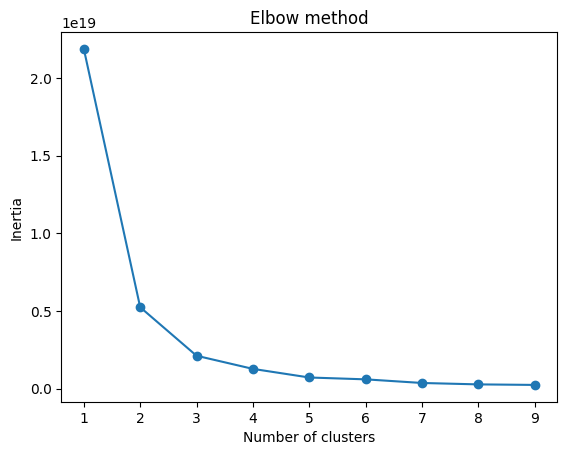

In [35]:
# Borrowed from https://www.w3schools.com/python/python_ml_k-means.asp#:~:text=K%2Dmeans%20is%20an%20unsupervised,the%20variance%20in%20each%20cluster.

num_clusters_tried = 10
inertias = []
for i in range(1, num_clusters_tried):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(datanp)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,num_clusters_tried), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## 2.3. SVD

Below is the SVD decomposition for our input data:\
\
The $U$ matrix represents the \"eigen\" data points for the input data,
representing an orthonormal basis for the data. The most significant
basis vector by definition of SVD decomposition is the first column of
the $U$ vector:


In [36]:
arr = np.array(data)
arrT = arr.transpose()

U, D, V = np.linalg.svd(arrT)

display(U)



array([[-1.34038736e-09,  3.74642267e-09,  1.84797553e-07, ...,
         3.90211678e-18, -1.03861985e-18, -4.48995225e-17],
       [-9.99999999e-01, -1.56887180e-05, -3.00776436e-05, ...,
         1.60270806e-18,  4.40894329e-19,  1.43114688e-17],
       [-1.33792918e-07,  1.47755091e-06,  1.49818333e-04, ...,
         7.29429792e-20, -1.05950296e-19, -3.98481605e-12],
       ...,
       [-1.88073229e-11, -1.30865944e-09,  2.22189589e-06, ...,
        -6.26448926e-04,  1.18416724e-04,  2.14747463e-02],
       [-1.56585772e-11, -1.00749555e-09,  2.04983563e-06, ...,
        -6.67076935e-04,  1.33869601e-04,  3.14712340e-02],
       [-4.37807440e-09, -1.28902316e-07,  3.37454528e-06, ...,
        -2.41790496e-05,  7.95843398e-06,  6.27488144e-03]])

In this vector, each element represents the general weighting assigned
to each feature. Thus, the vector will contain $N$ elements, where $N$
is the number of features. We will define the \"most significant\"
features as the features with the highest weights in this vector. Based
on this definition, below are the 10 most significant features and their
relative weights:

In [37]:
threshold = 0.01
top_eigenpoint = U[:1][0] # The highest weighted "eigen" data point

print(U.shape)

print("Most Significant Features (weight > {0}):\n".format(threshold))
print("Feature\t\t\t\tWeight")
print("------------------------------------------------")

most_sig_features = []
for i in range(top_eigenpoint.size):
    if(top_eigenpoint[i] > threshold):
        most_sig_features.append((i, df.columns[i], top_eigenpoint[i]))

most_sig_features.sort(key=lambda x:x[2],reverse=True)
for feature in most_sig_features:
    print("{0}. {1:<20}\t{2}".format(feature[0], feature[1], feature[2]))

(159, 159)
Most Significant Features (weight > 0.01):

Feature				Weight
------------------------------------------------
16. Wind x              	0.8149465236831045
14. Wind Speed(mph)     	0.10014270445143507
32. Civil_Twilight      	0.07715116931380682
22. Junction            	0.06687489577223638
28. Traffic_Calming     	0.036008568100889315
27. Stop                	0.030758651957351044
54. Light Freezing Rain 	0.03027905424800274
45. Heavy Rain          	0.029368795658261428
20. Crossing            	0.025622063545044302
82. Thunderstorms and Rain	0.024764043188853266
12. Pressure(in)        	0.02010499094039616
25. Roundabout          	0.01971952366450705
56. Light Rain / Windy  	0.01851604932854415
47. Heavy Snow          	0.01839686675376408
68. Patches of Fog      	0.01786765473577251
72. Shallow Fog         	0.01614101424164676
42. Fog / Windy         	0.015228836911873232
35. Clear               	0.015194268297566238
78. T-Storm / Windy     	0.014039769378308717
40. Fair / Win

## 2.4. Correlation Matrix

### 2.4.1. Correlation Matrix Graph

Below is the correlation matrix for our input data. We can visualize the matrix in a graph, where the yellow squares indicate a high positive correlation value and dark blue represents a high negative correlation value. We can see that the matrix is very sparse, with most of the values being 0. This is because the data is very high dimensional, and most of the features are not correlated with each other.

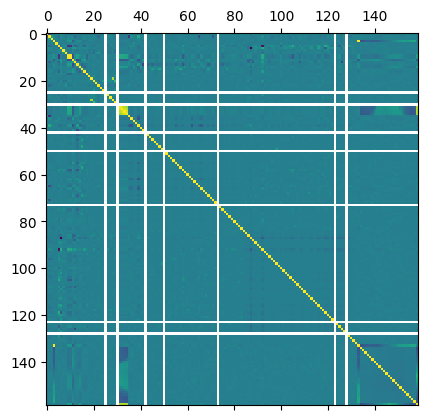

In [38]:
# corr = np.corrcoef(datanp, rowvar=False) # this is the numpy version
corr = datapd.corr()
plt.matshow(corr)
plt.show()

### 2.4.2. Most correlated features

Now we can print out which features are the most correlated to each other:

In [45]:
# print which columns are most correlated
features_and_correlations = []

for i in range(corr.shape[0]):
    for j in range(i,corr.shape[1]):
        if abs(corr.iloc[i,j]) > 0.75 and i != j:
            features_and_correlations.append((col_names[i], col_names[j], corr.iloc[i,j]))

# sort by absolute value of correlation
features_and_correlations.sort(key=lambda tup: abs(tup[2]), reverse=True)

for feature in features_and_correlations:
    print("Column", feature[0], "is correlated with Column " + feature[1] + " with correlation coefficient ", feature[2])



Column Seconds Since Start Of Day is correlated with Column Hour with correlation coefficient  0.9987862440293248
Column Temperature(F) is correlated with Column Wind Chill(F) with correlation coefficient  0.9937407066857632
Column Sunrise_Sunset is correlated with Column Civil_Twilight with correlation coefficient  0.9087310192841858
Column Nautical_Twilight is correlated with Column Astronomical_Twilight with correlation coefficient  0.8946474911220064
Column Civil_Twilight is correlated with Column Nautical_Twilight with correlation coefficient  0.8898932558892662
Column Sunrise_Sunset is correlated with Column Nautical_Twilight with correlation coefficient  0.8086736054783745
Column Civil_Twilight is correlated with Column Astronomical_Twilight with correlation coefficient  0.7965103713881412
Column Sunrise_Sunset is correlated with Column Amount of Light with correlation coefficient  0.7880149073056935
Column Civil_Twilight is correlated with Column Amount of Light with correlatio

There are some very obvious correlations: of course the time of day in seconds and the time of day in hours would be highly correlated. Additionally, different ways of measuring whether it is twillight or not agree with each other greatly. 

We can also see that the amount of light is highly correlated with the time of day, which makes sense. The correlation between the state and the longitude is also very high, which makes sense because the longitude is a function of the state. The correlation between the bump and traffic calming is also very high, which makes sense because they are both traffic calming structures.

### 2.4.3. Most correlated features with severity
For more helpful insights, let us see which features are the most correlated with the severity of the accident:

In [55]:
def print_highest_correlations(range11, range12, range21, range22, threshold):
    features_and_correlations = []

    for i in range(range11, range12):
        for j in range(range21, range22):
            if abs(corr.iloc[i,j]) > threshold and i != j:
                features_and_correlations.append((col_names[i], col_names[j], corr.iloc[i,j]))

    # sort by absolute value of correlation
    features_and_correlations.sort(key=lambda tup: abs(tup[2]), reverse=True)

    for feature in features_and_correlations:
        print("Column", feature[0], "is correlated with Column " + feature[1] + " with correlation coefficient ", feature[2])
        
# print which columns are most correlated to severity
print_highest_correlations(0,1 , 0, corr.shape[1], 0.1)


Column Severity is correlated with Column StartTime with correlation coefficient  -0.321382212382472
Column Severity is correlated with Column Clear with correlation coefficient  0.19121029302163745
Column Severity is correlated with Column Overcast with correlation coefficient  0.12776592301014056
Column Severity is correlated with Column Fair with correlation coefficient  -0.12678107169002412
Column Severity is correlated with Column CA with correlation coefficient  -0.11968013344828514
Column Severity is correlated with Column Scattered Clouds with correlation coefficient  0.11749484257745325
Column Severity is correlated with Column Start Longitude with correlation coefficient  0.11004470581532966
Column Severity is correlated with Column IL with correlation coefficient  0.10328313828756308
Column Severity is correlated with Column CO with correlation coefficient  0.10200421002367273


From the above results, it looks like the severity of the accident is most correlated with the time of day, some of the weather conditions, and to an extent some of the states the accident was in. This makes sense, as accidents are more likely to occur at certain times of day, when the weather is bad, and in states with certain road conditions or traffic laws.



### 2.4.4. Most correlated states with severity
Now let us look at which states are most correlated with accident severity (cheer on your home state!):

In [56]:
# print which states are most correlated to severity
print_highest_correlations(84,133 , 0, 1 , 0.05)


Column CA is correlated with Column Severity with correlation coefficient  -0.11968013344828514
Column IL is correlated with Column Severity with correlation coefficient  0.10328313828756308
Column CO is correlated with Column Severity with correlation coefficient  0.10200421002367273
Column GA is correlated with Column Severity with correlation coefficient  0.09862112580303628
Column WI is correlated with Column Severity with correlation coefficient  0.09482338524653496
Column MI is correlated with Column Severity with correlation coefficient  0.09279603653996518
Column MD is correlated with Column Severity with correlation coefficient  0.06878297910601239
Column FL is correlated with Column Severity with correlation coefficient  -0.06285354287716176
Column IN is correlated with Column Severity with correlation coefficient  0.05587722181260185
Column CT is correlated with Column Severity with correlation coefficient  0.052808331171607874
-----------------------------------------------

Notice that California has a negative correlation with the severity of the accident. This is because California has a lot of accidents, but the severity of the accidents is not as high as in other states. This is likely because California has a lot of traffic, and the accidents are more likely to be minor fender benders.
Illinois on the other hand has a very high correlation with the severity of the accident. This is likely because Illinois has a lot of accidents, and the severity of the accidents is also very high. This is likely because Illinois has a lot of traffic, and the accidents are more likely to be major accidents.

### 2.4.5. Most correlated hours with severity
Now let us look at the hours of the day that are most correlated with accident severity:

In [57]:
# print which hours are most correlated to severity
print_highest_correlations(133,159 , 0, 1 , 0.01)


Column Amount of Light is correlated with Column Severity with correlation coefficient  -0.02827384340330704
Column Hour_0 is correlated with Column Severity with correlation coefficient  0.027412230800836455
Column Hour_15 is correlated with Column Severity with correlation coefficient  -0.020081940858777764
Column Hour_13 is correlated with Column Severity with correlation coefficient  -0.019436581977669846
Column Hour_14 is correlated with Column Severity with correlation coefficient  -0.019434086393001176
Column Hour is correlated with Column Severity with correlation coefficient  -0.01888561779715926
Column Hour_18 is correlated with Column Severity with correlation coefficient  0.018206703262030846
Column Hour_3 is correlated with Column Severity with correlation coefficient  0.018073268672042186
Column Hour_8 is correlated with Column Severity with correlation coefficient  0.017376303440288763
Column Hour_9 is correlated with Column Severity with correlation coefficient  0.01688

It seems that the amount of light is negatively correlated with the severity of the accident. This is likely because the accidents are more likely to occur at night, when there is less light, and the severity of the accidents is higher at night. This is likely because there are more drunk drivers at night, and drunk drivers are more likely to cause accidents. We can also see a increase in correlation with severity in the early hours of the day for the same reason. Accidents that happen during later hours of the day are more likely to be minor fender benders, and accidents that happen during the early hours of the day are more likely to be major accidents.

### 2.4.6. Most correlated weather conditions with severity
Lastly, let us look at which weather conditions are most correlated with accident severity:

In [59]:
# print which weather conditions are most correlated to severity
print_highest_correlations(35,84 , 0, 1 , 0.01)


Column Clear is correlated with Column Severity with correlation coefficient  0.19121029302163745
Column Overcast is correlated with Column Severity with correlation coefficient  0.12776592301014056
Column Fair is correlated with Column Severity with correlation coefficient  -0.12678107169002412
Column Scattered Clouds is correlated with Column Severity with correlation coefficient  0.11749484257745325
Column Cloudy is correlated with Column Severity with correlation coefficient  -0.04763567674308661
Column Thunderstorm is correlated with Column Severity with correlation coefficient  0.03738273283714851
Column Light Freezing Rain is correlated with Column Severity with correlation coefficient  0.029501211837612586
Column Fair / Windy is correlated with Column Severity with correlation coefficient  0.02641293218049584
Column Heavy Snow is correlated with Column Severity with correlation coefficient  0.02573269200482215
Column Thunder is correlated with Column Severity with correlation c

This is very interesting. It looks like the severity of the accident is most correlated with the weather conditions of "Clear" and "Overcast". This is likely because these weather conditions are the most common, and thus the most likely to occur. But if we calculate the mean of Clear vs eg. Snow, we do see that accidents are actually more severe in clear weather. This seems paradoxical, but it is what the data shows. Strange!